In [ ]:
#-----#
#Used for Vb-Vt and Vb+Vt sweeping of Keithley SMUs, for recording I,V from Keithleys and Nanovoltmeters
#Using QCodes for data storage, 
#Use plottr-inspectr for real-time plotting (open separately)

#Created by Lewis P, Eli H & Chenxi Li
#Updated 16/10/2025



In [1]:
from import_all import *
from utilities import *

In [2]:
#----Connect to instrument----#
#load the station from yaml configuration file
station = Station(config_file="electrochemistry.station.yaml")
keithley1 = station.load_keithley1()
keithley2 = station.load_keithley2()
# nano1 = station.load_nanovoltmeter1()
# nano2 = station.load_nanovoltmeter2()

Connected to: Keithley Instruments Inc. 2636B (serial:4629010, firmware:3.4.0) in 0.55s
Connected to: Keithley Instruments Inc. 2614B (serial:4070377, firmware:3.0.4) in 0.47s


In [220]:
#----Save paths----#
csv_save_path = "../csv/250513/"
db_save_path = "../db/250513/"
device_name = "250510_gr-hBN-5um-device_63" #master database file
xpmnt_name = "n(0to4-5V_5mVs)_E(m0-4)_ds(0-5mV)_80C"#xpmnt name within database. Saved as seperate csv
# xpmnt_name = "n(0)_E(m0-5to0-5V_10mv/s)_ds(0mV)_RT"#xpmnt name within database. Saved as seperate csv


In [221]:
####################################
#----Configure channels----#
####################################

top_gate = { "channel": keithley1.smua,
        "name": "top_gate",
        "independent":  True, # default = True   
        "threshold_check": False,
        "threshold": 0,          
}

bottom_gate = { "channel": keithley1.smub,
        "name": "bottom_gate",
        "independent":  False, 
        "threshold_check": False,
        "threshold": 200e-12,      # default = False        
}


drain_source = { "channel": keithley2.smub,
        "name": "drain_source",
        "independent":  False,
         "threshold_check": False,
        "threshold": 0, # default = False         
}

tempDict = { "channel": keithley2.smua,
        "name": "temperature",
        "independent":  False,
         "threshold_check": False,
        "threshold": 0, # default = False         
}

# topRef = { "channel": nano1,
#         "name": "nano1",
#         "independent":  False, # default = False         
# }

# bottomRef = { "channel": nano2,
#         "name": "nano2",
#         "independent":  False, # default = False         
# }

####################################
#----Configure sweeper----#
####################################
sweepE =False # if not sweepE, then sweep n

time_independent = False  #plot time as indepent variable? 

ramp_up = True # ramp to initial values?
ramp_down = True #ramp back to 0?
round_ramp =False #ramp to new configuration each time vt+vb changes? Useful for sparse map, unecessary for full map

#----Set gate and drain source parameters
e_lims = [-0.4,-0.4] # max and min E
e_start = -0.4
dV_e = 0.0 # number of E values
e_return =True

n_lims = [0, 4.5] #max and min of n
n_start = 0
dV_n = 0.005 #voltage step for n
n_return = True

fixed_voltage = 5e-4 # drain source voltage
temp_voltage = 5e-3 # voltage applied across thermistor

temp_measure = True

ktime_control = True


########----Scanning parameters----######
dt = 1
delayNPLC_ratio = 0.7 #ratio of wait/integrate
n_measurements = 4

start_delay = 30 #time between setting initial voltages and beginning scan
round_delay=0 #round delay is the delay built in between succesive loops through intercepts (each back-forward trace)
repeat = 1 #how many times to repeat entire map
forward_write_period = 2

sweepers = [top_gate, bottom_gate, drain_source, tempDict]
sweepers_save_order = [top_gate, bottom_gate, drain_source,tempDict] #Order for saving in database, for easy parsing of data in plottr-inspectr
channels_save_order = [top_gate["channel"], bottom_gate["channel"], drain_source["channel"],
                        tempDict["channel"]] #Order for saving in database, for easy parsing of data in plottr-inspectr



In [222]:
###### Perform checks ######
i = 0
for sweeper in sweepers:
    if sweeper["independent"]:
        i+=1

if time_independent:
    i+=1
if not i == 1:
    print("-- Greater or fewer than 1 channel is independent. Plottr-inspectr my not function correctly")

if not ramp_up:
    print("-- Voltages will start instaneously at initial values. Are you sure you don't want to ramp?")


if not ktime_control:
    print("-- Measurement time on Keithley is not controlled. Make sure appropriate speeds are set manually")

In [223]:
if ktime_control:
    nplc_set = dt*50*(1-delayNPLC_ratio)/(n_measurements)
    delay = dt - (nplc_set/50)*n_measurements

    sweepers_save_order[0]["channel"].delay(delay)
    sweepers_save_order[0]["channel"].nplc(nplc_set)

    for sweeper in sweepers_save_order[1:]:
        if not "nano" in sweeper["name"]:
            sweeper["channel"].delay(0)
        sweeper["channel"].nplc(nplc_set)

In [224]:
def wave(start, p1, p2, d, goback = False):
    if d == 0:
        return [start]
    nPoints = 1+abs(int((p1-start)/d))
    s1 = np.linspace(start,p1, nPoints)

    nPoints = 1+abs(int((p2-p1)/d))
    s2 = np.linspace(p1,p2, nPoints)

    nPoints = 1+abs(int((start-p2)/d))
    s3 = np.linspace(p2,start, nPoints)

    if goback:
        s = np.concatenate((s1[:-1],s2[:-1],s3))
    else:
        s = np.concatenate((s1[:-1],s2))

    return s

Single gate scan speed = 2.5 mV/s
Min top gate voltage = -0.2 V
Min bottom gate voltage = 0.2 V
Max top gate voltage = 2.05 V
Max bottom gate voltage = 2.45 V
[-0.4]


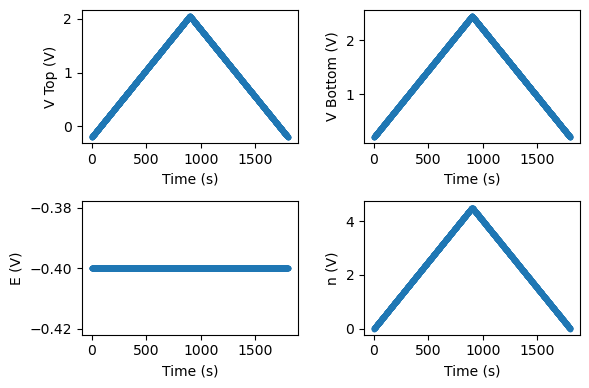

In [225]:

#-----Create voltage arrays, and plot----#
es = wave(e_start, e_lims[0], e_lims[1], dV_e, goback=e_return)
ns = wave(n_start, n_lims[0], n_lims[1], dV_n, goback=n_return)



t = [dt*x for x in range(len(ns)*len(es))]

X = []
Y = []
E = []
N = []

if not sweepE: #sweep N
    dV_sweep = dV_n
    for eField in es:
        for n in ns:
            x,y = calcXY(eField, n)
            X.append(x)
            Y.append(y)
            E.append(eField)
            N.append(n)

else: # sweep E
    dV_sweep = dV_e
    for n in ns:
        for eField in es:
            x,y = calcXY(eField, n)
            X.append(x)
            Y.append(y)
            E.append(eField)
            N.append(n)



print(f'Single gate scan speed = {0.5*1000*dV_sweep/dt} mV/s')

print(f'Min top gate voltage = {min(X)} V')
print(f'Min bottom gate voltage = {min(Y)} V')

print(f'Max top gate voltage = {max(X)} V')
print(f'Max bottom gate voltage = {max(Y)} V')

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(t,X, marker = '.')
ax2.plot(t,Y, marker = '.')
ax3.plot(t,E,marker = '.')
print(np.unique(E))
ax4.plot(t,N,marker = '.')

ax1.set_ylabel('V Top (V)')
ax2.set_ylabel('V Bottom (V)')
ax3.set_ylabel('E (V)')
ax4.set_ylabel('n (V)')

ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Time (s)')
ax3.set_xlabel('Time (s)')
ax4.set_xlabel('Time (s)')
fig.tight_layout()




In [226]:
#----Connect to database----#
initialise_or_create_database_at(f'{db_save_path}{device_name}_nSweeper.db')
#Set up experiment object
test_exp = load_or_create_experiment(
    experiment_name=xpmnt_name,
    sample_name=device_name,
)

meas_forward, time,_independent_params = setup_database_registers_arb(station, test_exp, sweepers_save_order, time_independent=time_independent)
meas_forward.write_period = forward_write_period


In [227]:
def threshold_check(n1, n2):
    # n1 is threshold, n2 is value
    if n1 < 0:
        if n1 > n2:
            return True
        
    else:
        if n1 < n2:
            return True
        
    return False

In [228]:
def threshold_event(sweepers):
        
        ramp_two_voltage(sweepers[0]["channel"], sweepers[1]["channel"], 0, 0, reset=False, x_initial = sweepers[0]["channel"].volt(), y_initial = sweepers[1]["channel"].volt())


In [ ]:
#----Run Mapping----#
#ramp voltages to initial values, from 0
#initial values: 
x_initial = X[0]
y_initial = Y[0]

if ramp_up:
    print('-----Set DACs to initial values and set DS-----')
    x_current = top_gate["channel"].volt()
    y_current = bottom_gate["channel"].volt()
    ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], x_initial, y_initial, x_initial = x_current, y_initial = y_current, reset=False) # ramp to initial voltages

print(f"Setting DS voltage to {fixed_voltage} V")
ramp_voltage(drain_source["channel"],fixed_voltage)
drain_source["voltage"] = fixed_voltage

if temp_measure:
    tempDict["voltage"] = temp_voltage
    tempDict["channel"].volt(temp_voltage)

print('-----Begin sweeps-----')
sleep(start_delay)
time.reset_clock()

if sweepE:
    firstList = ns
    secondList = es
else:
    firstList = es
    secondList = ns

threshold_check = False
with meas_forward.run() as forward_saver:
    for _ in range(repeat):
        for f in firstList:
            first_point = True
            for s in secondList:
                
                if sweepE:
                    n = f
                    eField = s
                else:
                    eField = f
                    n = s
                    
                x,y = calcXY(eField, n)
                top_gate["voltage"] = x
                bottom_gate["voltage"] = y
                if round_ramp and first_point:
                    ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], x, y, reset = False,
                    x_initial = top_gate["channel"].volt(), y_initial = bottom_gate["channel"].volt())
                    first_point = False
        
                else:
                    top_gate["channel"].volt(x)
                    bottom_gate["channel"].volt(y)
                
                result = []

                if not ktime_control:
                    sleep(dt)
                    
                for sweeper in sweepers:
                    chan = sweeper["channel"]
                    if not "nano" in sweeper["name"]:
                        j = chan.curr()
                        result.append((chan.curr, j))
                        v = sweeper["voltage"]
                    else:
                        v = chan.volt()

                    result.append((chan.volt, v))
                    
                    if sweeper["threshold_check"]:
                        threshold_met = threshold_check(sweeper["threshold"],j)
                        if threshold_met:
                            print(f'threshold met: {sweeper["name"]} at {j}')


                    if "temperature" in sweeper["name"]:
                        try:
                            temperature = rToT(v/j)
                        except:
                            temperature = 0
                            print("TEMP MEASUREMENT FAILED")
                        result.append((chan.temperature, temperature))

                t = time()
                result.append((time, t))
                forward_saver.add_result(*result)

                if threshold_met:
                    threshold_event([top_gate,bottom_gate])
                    break
                    
            data_forward = forward_saver.dataset

#save data to csv
data_forward.to_pandas_dataframe().to_csv(f"{csv_save_path}{device_name}_{xpmnt_name}_forward_{data_forward.run_id}.csv")
j
# Ramping voltage back to 0

if ramp_down:
    ramp_voltage(top_gate["channel"],0)
    ramp_voltage(bottom_gate["channel"],0)
    ramp_voltage(drain_source["channel"],0)


-----Set DACs to initial values and set DS-----
ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> and <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> to -0.2 and 0.2
Setting DS voltage to 0.0005 V
ramping <Keithley2600Channel: keithley2_smub of Keithley2600: keithley2> from 0.000496674 to 0.0005
-----Begin sweeps-----
Starting experimental run with id: 3. 
ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> from -0.198984 to 0
ramping <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> from 0.199332 to 0
ramping <Keithley2600Channel: keithley2_smub of Keithley2600: keithley2> from 0.000491762 to 0
